<a href="https://colab.research.google.com/github/EbrahimiAmirHosein/Face-Recognition/blob/main/Emotion_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Dense,Activation
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report

# Reading Data

> Total of 28709 rows × 2 columns ,
> Using 80% of data as training set and other as test :
>> **train = 22967 , test = 2871 , val = 2871**

In [ ]:
def read_data(file_name):

    data = pd.read_csv(file_name) #28709 rows × 2 columns

    train_y , train_x = [] , []
    test_y , test_x = [] , []
    val_y , val_x = [] , []

    test_splitter = 0
    for index , row in data.iterrows():
        if test_splitter < 22967 and test_splitter >= 0:
            train_x.append(row['pixels'].split(" "))
            train_y.append(row['emotion'])
        elif test_splitter <= 25838 and test_splitter > 22967:
            test_x.append(row['pixels'].split(" "))
            test_y.append(row['emotion'])
        else :
            val_x.append(row['pixels'].split(" "))
            val_y.append(row['emotion'])
        test_splitter+=1

    return np.array(train_x ,"float64") , np.array(train_y,"float64") , np.array(test_x,"float64") , np.array(test_y,"float64") ,np.array(val_x,"float64") , np.array(val_y,"float64")


In [ ]:
X_train , Y_train , X_test , Y_test , X_Val , Y_Val = read_data('data.csv')

In [ ]:
def reshapetoImage(data):

    Images = data.reshape((data.shape[0], 48, 48, 1))

    return Images

In [ ]:
X_train = reshapetoImage(X_train)
X_test = reshapetoImage(X_test)
X_Val = reshapetoImage(X_Val)


### Visualaizing some Images

In [ ]:
def plotImages(x,y):
    emotions = [0,1,2,3,4,5,6]
    plt.figure(figsize=[20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(x[i],cmap="gray")
        plt.title(Y_train[i])
        plt.axis("off")
    plt.show()

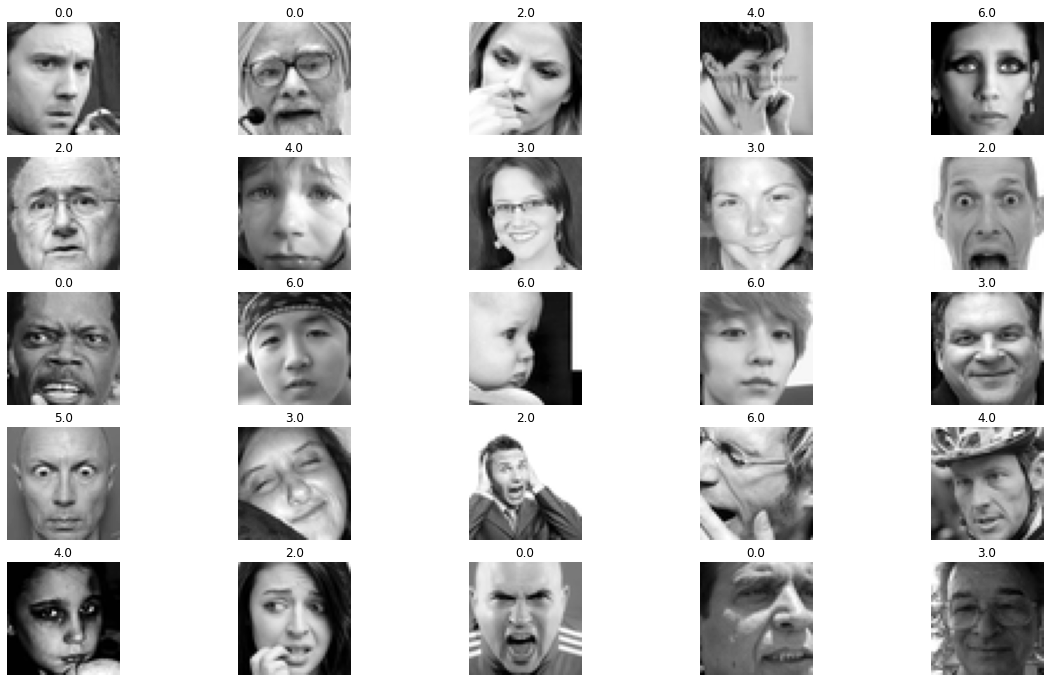

In [ ]:
plotImages(X_train , Y_train)

### Image Data Generator

In [ ]:
trainGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
                 )
valGen = Imgen(rescale=1./255,
                 zoom_range=0.2,
                 shear_range=0.2,
                 horizontal_flip=True
               )
testGen = Imgen(rescale=1./255)

In [ ]:
trainds = trainGen.flow(X_train,Y_train,
                   batch_size = 32
                   )

valds = valGen.flow(X_Val,Y_Val,
               batch_size = 32
               )

testds = testGen.flow(X_test,Y_test,
                      batch_size=32,
                      shuffle=False)



>> ***One batch***


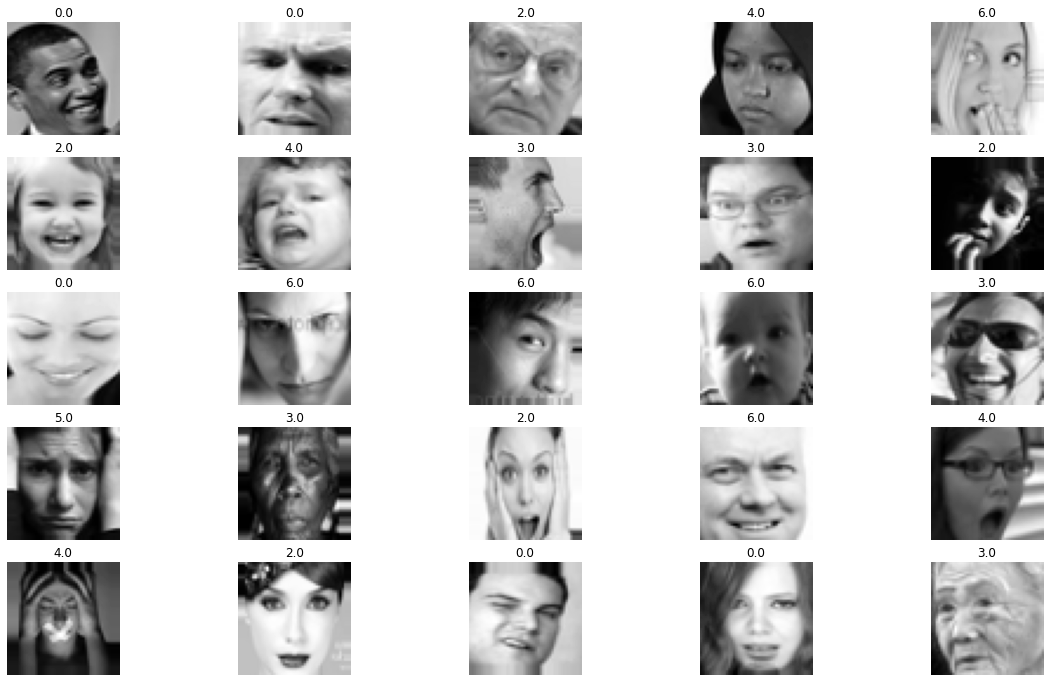

In [ ]:
# one batch
x,y = next(trainds)

# see
plotImages(x,y)

## Model

## Resnet of 3 residual block of 2 stages of my own


                  input ---------------
                    |                 |
            ------------------        |
           | 3 residual blocks|       | +
            ------------------        |
                    |                 |
                    <-----------------
                    |------------------
            ------------------        |
           | 3 residual blocks|       | +
            ------------------        |
                    |                 |
                    <-----------------
                    |
                    |
                ----------
                | Output |
                ----------

In [ ]:
image_input = Input(shape=(48,48,1))
x = image_input
skip = image_input

filters = [64,128,128,512]
bnEps = 2e-5
bnMom = 0.9
reg = 0.0001

x = Conv2D(filters[0],(3,3), activation="relu")(x)

#first block of ResNet
x = Conv2D(filters[1], kernel_size=1, strides=1)(x)
x = BatchNormalization( epsilon=bnEps, momentum = bnMom)(x)
x = Activation("relu")(x)

#second block of ResNet
x = Conv2D(filters[2], kernel_size=3, strides=1,padding = "same")(x)
x = BatchNormalization( epsilon=bnEps, momentum = bnMom)(x)
x = Activation("relu")(x)

#third block of ResNet
x = Conv2D(filters[2], kernel_size=3, strides=1, use_bias=False,padding = "same")(x)
x = BatchNormalization( epsilon=bnEps,momentum=bnMom)(x)

skip = Conv2D(filters[1], kernel_size=3)(skip)
skip = BatchNormalization( epsilon=bnEps,momentum=bnMom)(skip)

x = tf.keras.layers.add([x, skip])
x = Activation("relu")(x)


skip2 = x

x = Conv2D(filters[1], kernel_size=1)(x)
x = BatchNormalization( epsilon=bnEps, momentum = bnMom)(x)
x = Activation("relu")(x)

x = Conv2D(filters[2] , kernel_size = 3 , strides = 1 ,padding = "same")(x)
x = BatchNormalization( epsilon=bnEps, momentum = bnMom)(x)
x = Activation("relu")(x)


x = Conv2D(filters[2], kernel_size = 3, strides = 1 , use_bias=False,padding = "same")(x)
x = BatchNormalization( epsilon=bnEps,momentum=bnMom)(x)

x = tf.keras.layers.add([x, skip2])
x = Activation("relu")(x)
x = keras.layers.GlobalAveragePooling2D()(x)

image_output = Dense(7,activation="softmax")(x)

model = Model(image_input,image_output)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 46, 46, 64)   640         input_14[0][0]                   
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 46, 46, 128)  8320        conv2d_39[0][0]                  
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 46, 46, 128)  512         conv2d_40[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Compile the model
print("Compiling the Model....")
model.compile(optimizer='adam',loss = 'sparse_categorical_crossentropy', metrics=["accuracy"])
print("Model Compiled!")

Compiling the Model....
Model Compiled!


# Defining callbacks


In [ ]:
my_calls = [EarlyStopping(monitor='val_accuracy',patience=5),
            ModelCheckpoint("Model_ethnicity.h5",verbose=1,save_best_only=True)]

# Train

In [ ]:
hist = model.fit(trainds, epochs=30, validation_data=valds, callbacks=my_calls)

Epoch 1/30
718/718 [==============================] - 1147s 2s/step - loss: 1.7798 - accuracy: 0.2592 - val_loss: 2.3002 - val_accuracy: 0.2567

Epoch 00001: val_loss improved from inf to 2.30018, saving model to Model_ethnicity.h5
Epoch 2/30
718/718 [==============================] - 1112s 2s/step - loss: 1.7305 - accuracy: 0.2983 - val_loss: 2.0584 - val_accuracy: 0.2682

Epoch 00002: val_loss improved from 2.30018 to 2.05843, saving model to Model_ethnicity.h5
Epoch 3/30
718/718 [==============================] - 1092s 2s/step - loss: 1.6640 - accuracy: 0.3389 - val_loss: 1.8288 - val_accuracy: 0.2835

Epoch 00003: val_loss improved from 2.05843 to 1.82878, saving model to Model_ethnicity.h5
Epoch 4/30
718/718 [==============================] - 1089s 2s/step - loss: 1.5842 - accuracy: 0.3763 - val_loss: 1.6780 - val_accuracy: 0.3497

Epoch 00004: val_loss improved from 1.82878 to 1.67800, saving model to Model_ethnicity.h5
Epoch 5/30
718/718 [==============================] - 1089s 

## Test

In [ ]:
model.evaluate(testds)

90/90 [==============================] - 31s 337ms/step - loss: 1.2977 - accuracy: 0.5239


[1.2976930141448975, 0.5238592624664307]

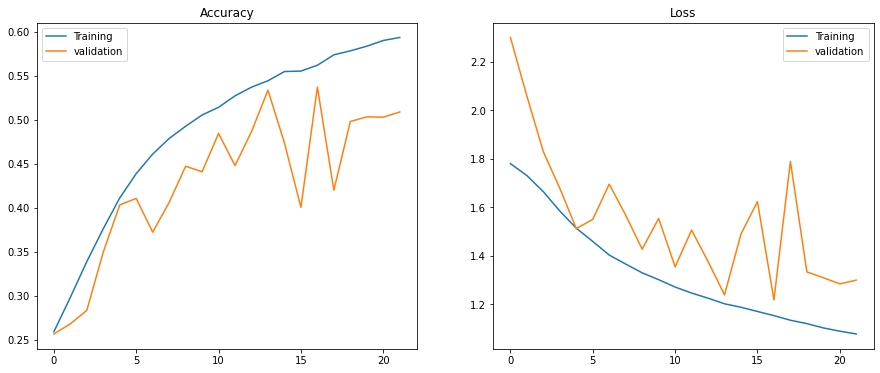

In [ ]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()